In [ ]:
%pip install gensim
%pip install googletrans==3.1.0a0
%pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
from pandas import read_csv, DataFrame, Series, concat
from googletrans import Translator
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from gensim.test.utils import datapath
import matplotlib.pyplot as plt
from numpy import arange
import re
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

In [ ]:
comments_df = read_csv('/content/gdrive/MyDrive/Courses/2 - Fall/21 - MIS 284N - Unstructured/Assignments/Project/comments.csv')
comments_df.head(5)

,user,nationality,current_location,comment_date,comment
0,Danny Ascencio,Argentina,"Dallas, Texas",2021-10-22,"In the fifa website, says November 21- Decembe..."
1,mazinio,NaN,NaN,2021-10-23,Where can u aee that. Can u please share the l...
2,Paul Calixte,NaN,"Miami, FL",2021-10-23,"Hi everyone,\n\nWith the incoming proliferatio..."
3,Danny Ascencio,Argentina,"Dallas, Texas",2021-10-25,"I spoke too soon, it says it will be available..."
4,Danny Ascencio,Argentina,"Dallas, Texas",2021-10-25,https://www.fifa.com/tournaments/mens/worldcup...


In [ ]:
translator = Translator()
word_tokenizer = TweetTokenizer()
wordnet_lemmatizer = WordNetLemmatizer()
stopwords_nltk=set(stopwords.words('english'))

In [ ]:
def text_pre_processing(sentence):
    sentence = translator.translate(sentence, dest="en").text
    sentence = sentence.lower()
    sentence = wordnet_lemmatizer.lemmatize(sentence)
    sentence = word_tokenizer.tokenize(sentence)
    return [token for token in sentence if token not in stopwords_nltk]

comments_df["comment_pp"] = comments_df["comment"].map(lambda x: text_pre_processing(x))

In [ ]:
comments_df.to_csv("comments_processed.csv", index=False)

In [ ]:
comments_df = read_csv("/content/gdrive/MyDrive/Courses/2 - Fall/21 - MIS 284N - Unstructured/Assignments/Project/comments_processed.csv")
comments_df["comment_pp"] = comments_df["comment_pp"].map(eval)

In [ ]:
comments_df["comment_pp"] = comments_df["comment_pp"].map(lambda lst: [word for word in lst if type(re.search("^\W*$", word)) == type(None)])

In [ ]:
dictionary = Dictionary(s for s in comments_df["comment_pp"].values)
corpus_vectors = [dictionary.doc2bow(text) for text in comments_df["comment_pp"].values]

In [ ]:
coherence_calculations = DataFrame(
    [],
    columns=["num_topics","score_type", "coherence_score"]
)

for k in range(2,12):
    ldamodel = LdaModel(corpus_vectors, num_topics=k, id2word=dictionary, passes=50)

    coherence_score = CoherenceModel(model=ldamodel, texts=comments_df["comment_pp"].values, dictionary=dictionary, coherence='c_v').get_coherence()
    coherence_calculations.loc[len(coherence_calculations)] = [k,"cv", coherence_score]
    
    coherence_score = CoherenceModel(model=ldamodel, texts=comments_df["comment_pp"].values, dictionary=dictionary, coherence='u_mass').get_coherence()
    coherence_calculations.loc[len(coherence_calculations)] = [k,"umass", coherence_score]

    coherence_score = CoherenceModel(model=ldamodel, texts=comments_df["comment_pp"].values, dictionary=dictionary, coherence='c_uci').get_coherence()
    coherence_calculations.loc[len(coherence_calculations)] = [k,"uci", coherence_score]

In [ ]:
coherence_calculations.to_csv("/content/gdrive/MyDrive/Courses/2 - Fall/21 - MIS 284N - Unstructured/Assignments/Project/coherence_scores_50.csv", index=False)

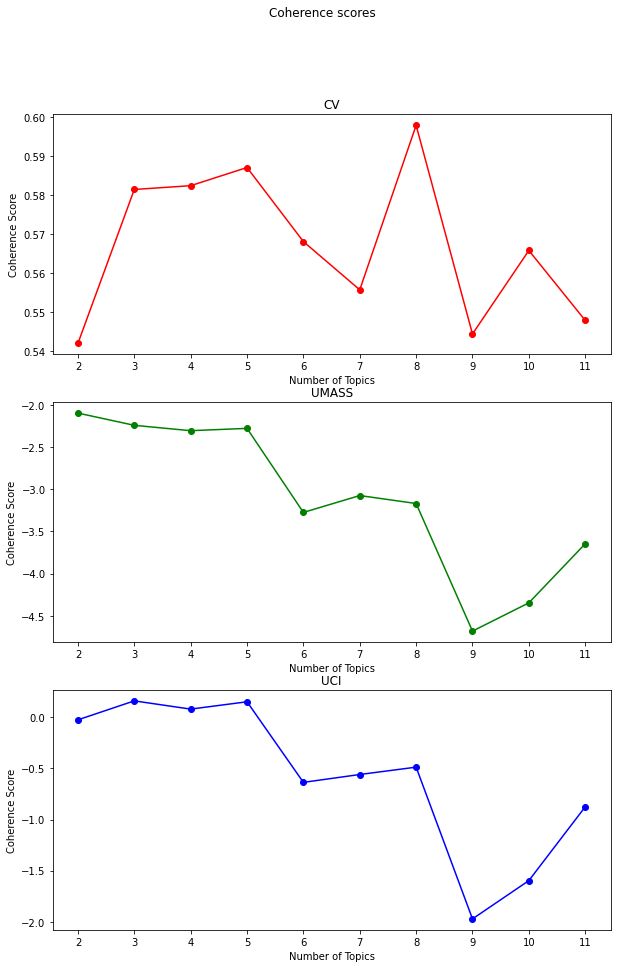

In [ ]:
fig, ax = plt.subplots( nrows=3,
                        ncols=1,
                        sharey=False,
                        sharex=False,  
                        figsize=(10, 15))
colors = ['red', 'green', 'blue']

for i, score_type in enumerate(['cv', 'umass', 'uci']):
    ax[i].xaxis.set_ticks(arange(0,14,1))
    ax[i].plot(coherence_calculations[coherence_calculations['score_type'] == score_type]['num_topics'],
               coherence_calculations[coherence_calculations['score_type'] == score_type]['coherence_score'],
               marker='o',
               linestyle='-',
               label='CV')
    ax[i].get_lines()[0].set_color(colors[i])
    ax[i].set_xlabel('Number of Topics')
    ax[i].set_ylabel('Coherence Score')
    ax[i].set_title(score_type.upper())

fig.suptitle('Coherence scores')
plt.show()

In [ ]:
ldamodel_5 = LdaModel(corpus_vectors, num_topics=5, id2word=dictionary, passes=50)
filePath = datapath("/content/gdrive/MyDrive/Courses/2 - Fall/21 - MIS 284N - Unstructured/Assignments/Project/lda_model")
ldamodel_5.save(filePath)

In [ ]:
filePath = datapath("/content/gdrive/MyDrive/Courses/2 - Fall/21 - MIS 284N - Unstructured/Assignments/Project/lda_model")
ldamodel_5 = LdaModel.load(filePath)
for num ,topic in ldamodel_5.show_topics(formatted=True, num_topics=5, num_words=10):
    print(str(num)+": "+ topic)

0: 0.018*"world" + 0.017*"cup" + 0.012*"qatar" + 0.010*"would" + 0.008*"people" + 0.008*"like" + 0.007*"fans" + 0.007*"think" + 0.007*"us" + 0.006*"going"
1: 0.010*"doha" + 0.008*"one" + 0.008*"stadium" + 0.007*"qatar" + 0.007*"al" + 0.007*"day" + 0.007*"hotel" + 0.007*"flight" + 0.006*"night" + 0.006*"flights"
2: 0.027*"tickets" + 0.019*"ticket" + 0.011*"fifa" + 0.011*"hayya" + 0.010*"card" + 0.010*"get" + 0.009*"one" + 0.008*"account" + 0.006*"portal" + 0.006*"email"
3: 0.058*"cat" + 0.037*"2" + 0.032*"1" + 0.028*"3" + 0.016*"seats" + 0.015*"4" + 0.010*"game" + 0.009*"games" + 0.008*"got" + 0.007*"hours"
4: 0.034*"tickets" + 0.018*"match" + 0.014*"matches" + 0.014*"games" + 0.013*"final" + 0.012*"group" + 0.012*"get" + 0.011*"vs" + 0.010*"ticket" + 0.009*"phase"


In [ ]:
topics = {
    0: "General_Conversation",
    1: "Accomodation_and_Venue",
    2: "Tickets",
    3: "Seating",
    4: "Matches"
}

In [ ]:
def format_topics_sentences(ldamodel, corpus, texts):
    sent_topics_df = DataFrame(
        [], columns = ['Topic_0_contribution', 'Topic_1_contribution','Topic_2_contribution','Topic_3_contribution','Topic_4_contribution', 'Dominant_Topic_index']
    )

    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list  
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        l = [0,0,0,0,0,0]
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                l[5] = int(topic_num)
            wp = ldamodel.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])
            l[int(topic_num)] = round(prop_topic,4)
        sent_topics_df.loc[len(sent_topics_df)] = l

    # Add original text to the end of the output
    contents = Series(texts)
    sent_topics_df = concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel_5, corpus=corpus_vectors, texts=comments_df["comment_pp"].values)
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.rename(columns={'index': 'Document_No', 0: 'Text'}, inplace=True)
df_dominant_topic

,Document_No,Topic_0_contribution,Topic_1_contribution,Topic_2_contribution,Topic_3_contribution,Topic_4_contribution,Dominant_Topic_index,Text
0,0,0.0184,0.3374,0.0189,0.0183,0.6070,4.0,"[fifa, website, says, november, 21, december, ..."
1,1,0.0289,0.0290,0.8844,0.0289,0.0288,2.0,"[u, see, u, please, share, link]"
2,2,0.2211,0.2656,0.1526,0.0422,0.3184,4.0,"[hi, everyone, incoming, proliferation, world,..."
3,3,0.1515,0.0145,0.0148,0.0144,0.8048,4.0,"[spoke, soon, says, available, due, course, ap..."
4,4,0.1000,0.1000,0.6000,0.1000,0.1000,2.0,[https://www.fifa.com/tournaments/mens/worldcu...
...,...,...,...,...,...,...,...,...
17956,17956,0.0126,0.0126,0.0127,0.3020,0.6601,4.0,"[finally, finished, see, seat, bought, best, s..."
17957,17957,0.0204,0.1426,0.0203,0.7934,0.0233,3.0,"[wish, finalize, give, hope, better, seats, 16..."
17958,17958,0.0251,0.1843,0.3061,0.1703,0.3142,4.0,"[seats, set, stone, supporters, tst's, imt, ac..."
17959,17959,0.2343,0.2500,0.1958,0.3078,0.0120,3.0,"[talk, location, seats, makes, wonder, anyone,..."


In [ ]:
final_comments = df_dominant_topic.merge(comments_df.reset_index(), left_on="Document_No", right_on="index")[
    ["Document_No", "Topic_0_contribution", "Topic_1_contribution", "Topic_2_contribution", "Topic_3_contribution", "Topic_4_contribution", "Dominant_Topic_index",
     "user", "nationality", "current_location", "comment_date", "comment", "Text"]
    ]
final_comments["Document_No"] = final_comments["Document_No"] + 1
final_comments.rename(columns={
    "Topic_0_contribution": topics[0]+"_TC",
    "Topic_1_contribution": topics[1]+"_TC",
    "Topic_2_contribution": topics[2]+"_TC",
    "Topic_3_contribution": topics[3]+"_TC",
    "Topic_4_contribution": topics[4]+"_TC",
    "Dominant_Topic_index": "dominant_topic",
}, inplace=True)
final_comments["dominant_topic"] = final_comments["dominant_topic"].map(lambda x: topics[int(x)])

In [ ]:
final_comments.to_csv("/content/gdrive/MyDrive/Courses/2 - Fall/21 - MIS 284N - Unstructured/Assignments/Project/final_comments_LDA.csv", index=False)

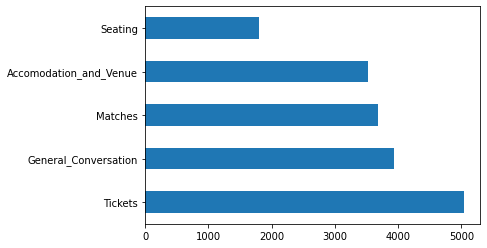

In [ ]:
final_comments["dominant_topic"].value_counts().plot.barh(color='#C08497')
plt.show()

In [ ]:
groups = final_comments.groupby("dominant_topic")

In [ ]:
df = DataFrame([], columns=["Topic", "Most Dominant Comment"])
for group_name, group_df in groups:
    df.loc[len(df)] = [group_name, re.sub('\s+', ' ', group_df.sort_values(group_name+"_TC", ascending=False).iloc[0]["comment"])]
df.to_csv("/content/gdrive/MyDrive/Courses/2 - Fall/21 - MIS 284N - Unstructured/Assignments/Project/Top_comment_by_topic.csv", index=False)